ANALYSE EN COMPOSANTES PRINCIPALES (ACP)
=========================================
Notebook de démonstration avec deux cas d'usage :
1. Données fortement corrélées
2. Données faiblement corrélées

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.linalg import cholesky

# Configuration pour de beaux graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# FONCTIONS UTILITAIRES
# ============================================================================


In [2]:

def generer_donnees_correlees(n_samples=200, n_features=10, seed=42):
    """
    Génère un dataset avec des variables fortement corrélées.
    
    Méthode : On crée 3-4 variables latentes et on génère les autres
    comme combinaisons linéaires avec du bruit.
    """
    np.random.seed(seed)
    
    # Créer 4 variables latentes de base
    latent = np.random.randn(n_samples, 4)
    
    # Matrice de coefficients pour créer de la corrélation
    # Chaque variable observée est une combinaison des variables latentes
    coef_matrix = np.array([
        [0.9, 0.1, 0.0, 0.0],  # Var1 surtout liée à latent1
        [0.8, 0.2, 0.0, 0.0],  # Var2 surtout liée à latent1
        [0.7, 0.3, 0.0, 0.0],  # Var3 surtout liée à latent1
        [0.1, 0.9, 0.0, 0.0],  # Var4 surtout liée à latent2
        [0.2, 0.8, 0.0, 0.0],  # Var5 surtout liée à latent2
        [0.0, 0.1, 0.9, 0.0],  # Var6 surtout liée à latent3
        [0.0, 0.2, 0.8, 0.0],  # Var7 surtout liée à latent3
        [0.0, 0.0, 0.1, 0.9],  # Var8 surtout liée à latent4
        [0.0, 0.0, 0.2, 0.8],  # Var9 surtout liée à latent4
        [0.3, 0.3, 0.2, 0.2],  # Var10 mélange de tout
    ])
    
    # Générer les données
    X = latent @ coef_matrix.T
    
    # Ajouter un peu de bruit
    X += np.random.randn(n_samples, n_features) * 0.2
    
    # Créer le DataFrame
    colonnes = [f'Var{i+1}' for i in range(n_features)]
    df = pd.DataFrame(X, columns=colonnes)
    
    return df


def generer_donnees_non_correlees(n_samples=200, n_features=10, seed=42):
    """
    Génère un dataset avec des variables faiblement corrélées.
    
    Méthode : Chaque variable est générée indépendamment.
    """
    np.random.seed(seed)
    
    # Générer chaque variable indépendamment avec des distributions différentes
    data = []
    for i in range(n_features):
        # Alterner entre différentes distributions pour plus de diversité
        if i % 3 == 0:
            var = np.random.normal(loc=i*2, scale=1+i*0.1, size=n_samples)
        elif i % 3 == 1:
            var = np.random.exponential(scale=1+i*0.2, size=n_samples)
        else:
            var = np.random.uniform(low=-i, high=i+5, size=n_samples)
        data.append(var)
    
    X = np.array(data).T
    
    # Créer le DataFrame
    colonnes = [f'Var{i+1}' for i in range(n_features)]
    df = pd.DataFrame(X, columns=colonnes)
    
    return df


def effectuer_acp(df, n_components=None):
    """
    Effectue une ACP sur le DataFrame.
    
    Retourne :
    - pca : objet PCA fitted
    - X_pca : données transformées
    - X_scaled : données standardisées
    """
    # Standardisation (CRITIQUE pour l'ACP)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    
    # ACP
    if n_components is None:
        n_components = min(df.shape)
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    return pca, X_pca, X_scaled


def plot_variance_expliquee(pca, title="Variance Expliquée"):
    """
    Graphique de la variance expliquée par chaque composante.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Variance expliquée par composante
    axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1),
                pca.explained_variance_ratio_ * 100)
    axes[0].set_xlabel('Composante Principale', fontsize=12)
    axes[0].set_ylabel('% Variance Expliquée', fontsize=12)
    axes[0].set_title('Variance Expliquée par Composante', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Variance expliquée cumulée
    variance_cumulee = np.cumsum(pca.explained_variance_ratio_) * 100
    axes[1].plot(range(1, len(variance_cumulee) + 1), variance_cumulee, 
                 marker='o', linewidth=2, markersize=8, color='coral')
    axes[1].axhline(y=80, color='red', linestyle='--', label='Seuil 80%')
    axes[1].set_xlabel('Nombre de Composantes', fontsize=12)
    axes[1].set_ylabel('% Variance Expliquée Cumulée', fontsize=12)
    axes[1].set_title('Variance Expliquée Cumulée', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Afficher les valeurs
    print(f"\n{'Composante':<15} {'% Variance':<15} {'% Cumulé'}")
    print("-" * 45)
    for i, (var, cum) in enumerate(zip(pca.explained_variance_ratio_, variance_cumulee)):
        print(f"CP{i+1:<13} {var*100:>6.2f}%{cum:>18.2f}%")


def plot_individus(X_pca, title="Graphe des Individus"):
    """
    Graphique des individus projetés sur les 2 premières composantes.
    """
    plt.figure(figsize=(10, 8))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    plt.xlabel(f'CP1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
    plt.ylabel(f'CP2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.8)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_variables(pca, feature_names, title="Cercle de Corrélation des Variables"):
    """
    Cercle de corrélation des variables.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Dessiner le cercle
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linewidth=2)
    ax.add_patch(circle)
    
    # Projeter les variables
    for i, feature in enumerate(feature_names):
        x = pca.components_[0, i]
        y = pca.components_[1, i]
        
        # Dessiner la flèche
        ax.arrow(0, 0, x, y, head_width=0.05, head_length=0.05, 
                fc='blue', ec='blue', linewidth=2, alpha=0.7)
        
        # Ajouter le label
        ax.text(x * 1.15, y * 1.15, feature, fontsize=11, 
               ha='center', va='center', fontweight='bold')
    
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_xlabel(f'CP1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
    ax.set_ylabel(f'CP2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.8)
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

def analyser_correlations(df, title="Matrice de Corrélation"):
    """
    Affiche la matrice de corrélation du dataset.
    """
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=0.5,
                cbar_kws={"shrink": 0.8})
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Statistiques de corrélation
    corr_values = corr.values[np.triu_indices_from(corr.values, k=1)]
    print(f"\nStatistiques des corrélations :")
    print(f"  Moyenne : {np.mean(np.abs(corr_values)):.3f}")
    print(f"  Médiane : {np.median(np.abs(corr_values)):.3f}")
    print(f"  Max : {np.max(np.abs(corr_values)):.3f}")
    print(f"  Min : {np.min(np.abs(corr_values)):.3f}")


# ============================================================================
# LAB 1 : DONNÉES FORTEMENT CORRÉLÉES
# ============================================================================


In [3]:
print("="*80)
print("LAB 1 : ANALYSE DE DONNÉES FORTEMENT CORRÉLÉES")
print("="*80)

LAB 1 : ANALYSE DE DONNÉES FORTEMENT CORRÉLÉES


In [4]:
# Génération des données
print("\n1. Génération du dataset...")
df_correlees = generer_donnees_correlees(n_samples=200, n_features=10, seed=42)
print(f"   Dataset créé : {df_correlees.shape[0]} observations, {df_correlees.shape[1]} variables")
print("\nAperçu des données :")
print(df_correlees.head())




1. Génération du dataset...
   Dataset créé : 200 observations, 10 variables

Aperçu des données :
       Var1      Var2      Var3      Var4      Var5      Var6      Var7  \
0  0.620873  0.266510  0.325445 -0.167222 -0.098168  0.507259  0.534925   
1 -0.271526 -0.322096  0.055247 -0.194828 -0.027771  1.100766  1.269953   
2 -0.471729  0.014802  0.293916  0.368789  0.251053 -0.072143  0.053692   
3 -0.242452 -0.372817 -0.605439 -1.851316 -1.489169 -1.696911 -1.452490   
4 -0.890016 -0.612452 -0.839252  0.258021  0.082122 -0.687307 -0.605736   

       Var8      Var9     Var10  
0  1.339746  1.599113  0.362757  
1  1.026539  0.946247  0.541938  
2 -0.570071 -0.549305 -0.220261  
3 -0.878221 -0.597949 -1.001634  
4 -0.870816 -1.438996 -0.779840  



2. Analyse des corrélations...


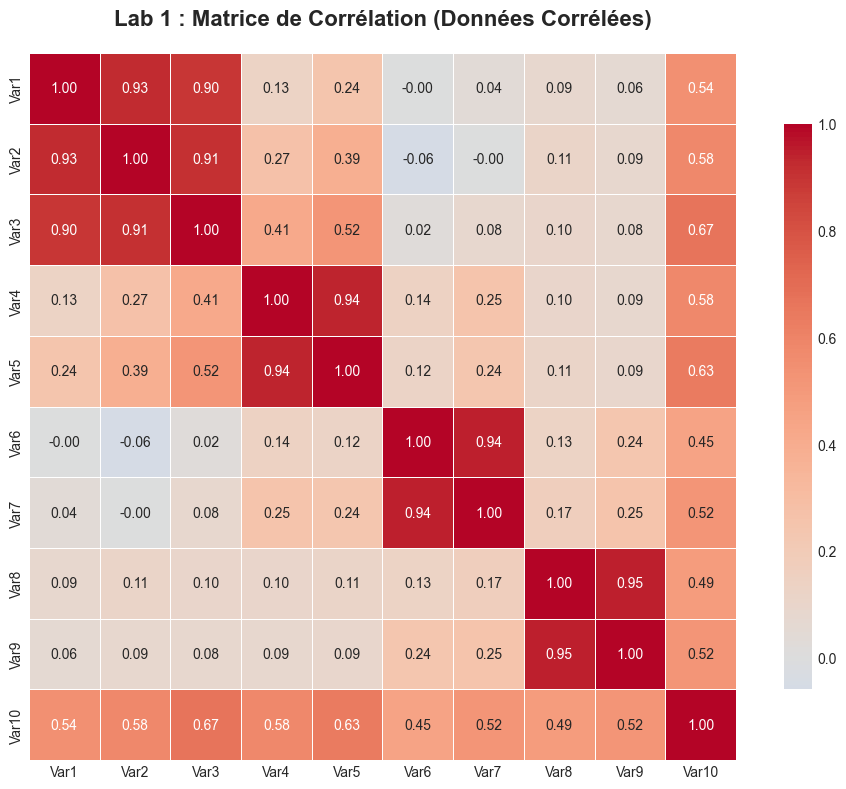


Statistiques des corrélations :
  Moyenne : 0.337
  Médiane : 0.238
  Max : 0.949
  Min : 0.002


In [5]:
# Analyse des corrélations
print("\n2. Analyse des corrélations...")
analyser_correlations(df_correlees, "Lab 1 : Matrice de Corrélation (Données Corrélées)")


In [6]:
# ACP
print("\n3. Application de l'ACP...")
pca, X_pca, X_scaled = effectuer_acp(df_correlees)


3. Application de l'ACP...



4. Analyse de la variance expliquée...


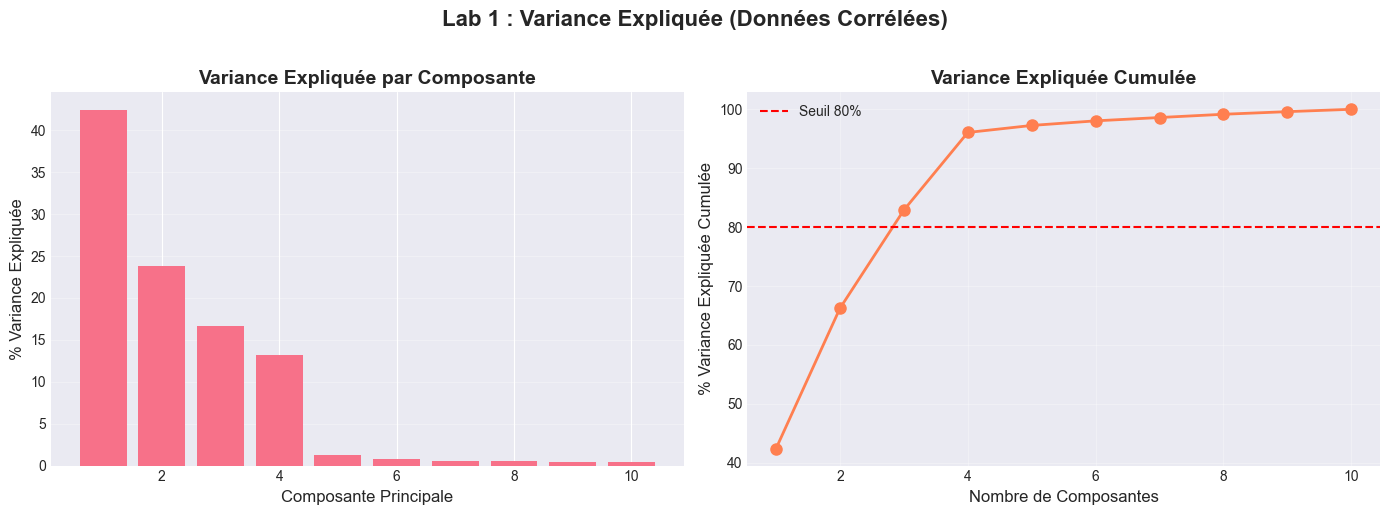


Composante      % Variance      % Cumulé
---------------------------------------------
CP1              42.41%             42.41%
CP2              23.81%             66.22%
CP3              16.67%             82.89%
CP4              13.17%             96.07%
CP5               1.19%             97.26%
CP6               0.78%             98.04%
CP7               0.56%             98.60%
CP8               0.55%             99.16%
CP9               0.44%             99.60%
CP10              0.40%            100.00%


In [7]:
# Variance expliquée
print("\n4. Analyse de la variance expliquée...")
plot_variance_expliquee(pca, "Lab 1 : Variance Expliquée (Données Corrélées)")



5. Graphe des individus...


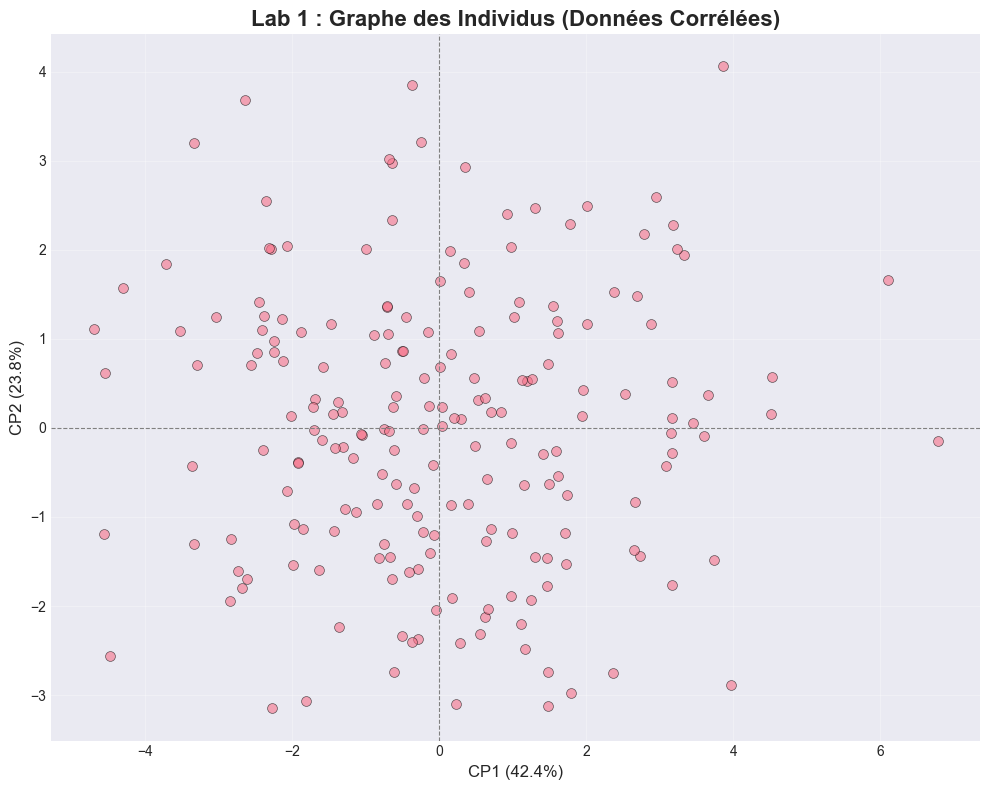

In [8]:
# Graphe des individus
print("\n5. Graphe des individus...")
plot_individus(X_pca, "Lab 1 : Graphe des Individus (Données Corrélées)")


6. Cercle de corrélation des variables...


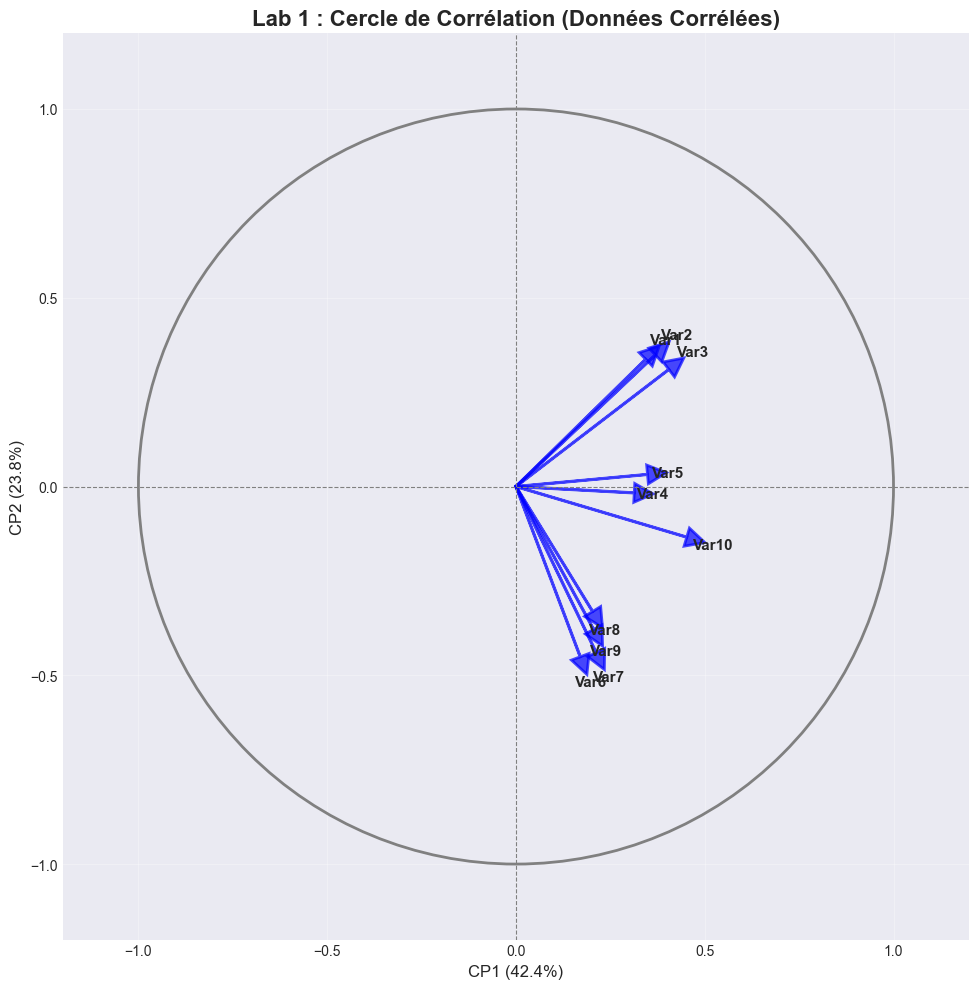


📊 INTERPRÉTATION du cercle de corrélation :


In [18]:
# Cercle de corrélation
print("\n6. Cercle de corrélation des variables...")
plot_variables(pca, df_correlees.columns, "Lab 1 : Cercle de Corrélation (Données Corrélées)")

print("\n📊 INTERPRÉTATION du cercle de corrélation :")
# print("   - Flèches groupées → Variables fortement corrélées entre elles")
# print("   - Flèches proches du cercle → Bien représentées dans le plan")
# print("   - Direction des flèches → Indique leur contribution aux composantes")

In [11]:
# Résumé
print("\n" + "="*80)
print("RÉSUMÉ LAB 1")
print("="*80)
variance_80 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.80) + 1
print(f"✓ Nombre de composantes pour 80% de variance : {variance_80}")
print(f"✓ Variance expliquée par CP1 et CP2 : {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100:.1f}%")
print("✓ L'ACP est TRÈS EFFICACE avec des données corrélées !")
print("✓ Réduction dimensionnelle importante possible")



RÉSUMÉ LAB 1
✓ Nombre de composantes pour 80% de variance : 3
✓ Variance expliquée par CP1 et CP2 : 66.2%
✓ L'ACP est TRÈS EFFICACE avec des données corrélées !
✓ Réduction dimensionnelle importante possible


# ============================================================================
# LAB 2 : DONNÉES FAIBLEMENT CORRÉLÉES
# ============================================================================


In [12]:
print("\n\n" + "="*80)
print("LAB 2 : ANALYSE DE DONNÉES FAIBLEMENT CORRÉLÉES")
print("="*80)



LAB 2 : ANALYSE DE DONNÉES FAIBLEMENT CORRÉLÉES


In [13]:
# Génération des données
print("\n1. Génération du dataset...")
df_non_correlees = generer_donnees_non_correlees(n_samples=200, n_features=10, seed=42)
print(f"   Dataset créé : {df_non_correlees.shape[0]} observations, {df_non_correlees.shape[1]} variables")
print("\nAperçu des données :")
print(df_non_correlees.head())


1. Génération du dataset...
   Dataset créé : 200 observations, 10 variables

Aperçu des données :
       Var1      Var2      Var3      Var4      Var5      Var6       Var7  \
0  0.496714  2.518330  6.659553  5.154165  1.606172  7.237497  14.107831   
1 -0.138264  1.620041  1.373835  5.366737  0.561711 -1.633391  12.316159   
2  0.647689  1.432889  0.571409  5.229888  1.761412 -1.642736  15.320417   
3  1.523030  1.454745  5.817392  4.876812  0.947945  3.054616  10.897299   
4 -0.234153  0.534591  0.012363  6.063078  1.445521  3.894099  14.777542   

       Var8      Var9      Var10  
0  4.396116 -5.695540  20.319964  
1  5.526759  3.507149  19.105986  
2  1.046545  1.541924  17.569680  
3  0.648786  9.731499  16.177065  
4  3.639646 -5.940266  17.292807  



2. Analyse des corrélations...


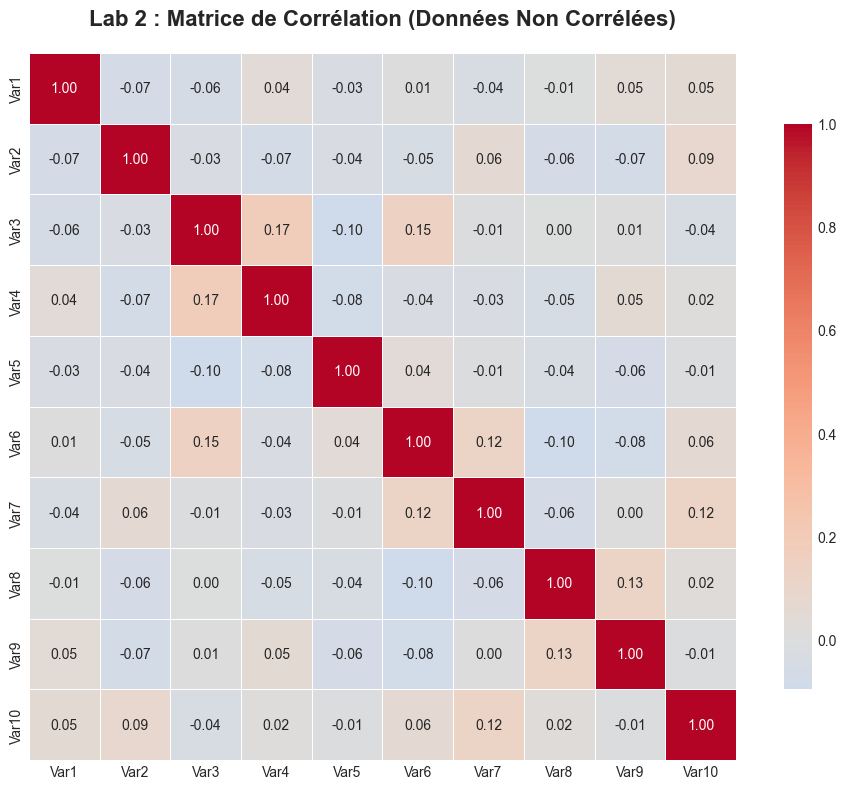


Statistiques des corrélations :
  Moyenne : 0.054
  Médiane : 0.052
  Max : 0.174
  Min : 0.000


In [14]:
# Analyse des corrélations
print("\n2. Analyse des corrélations...")
analyser_correlations(df_non_correlees, "Lab 2 : Matrice de Corrélation (Données Non Corrélées)")


3. Application de l'ACP...

4. Analyse de la variance expliquée...


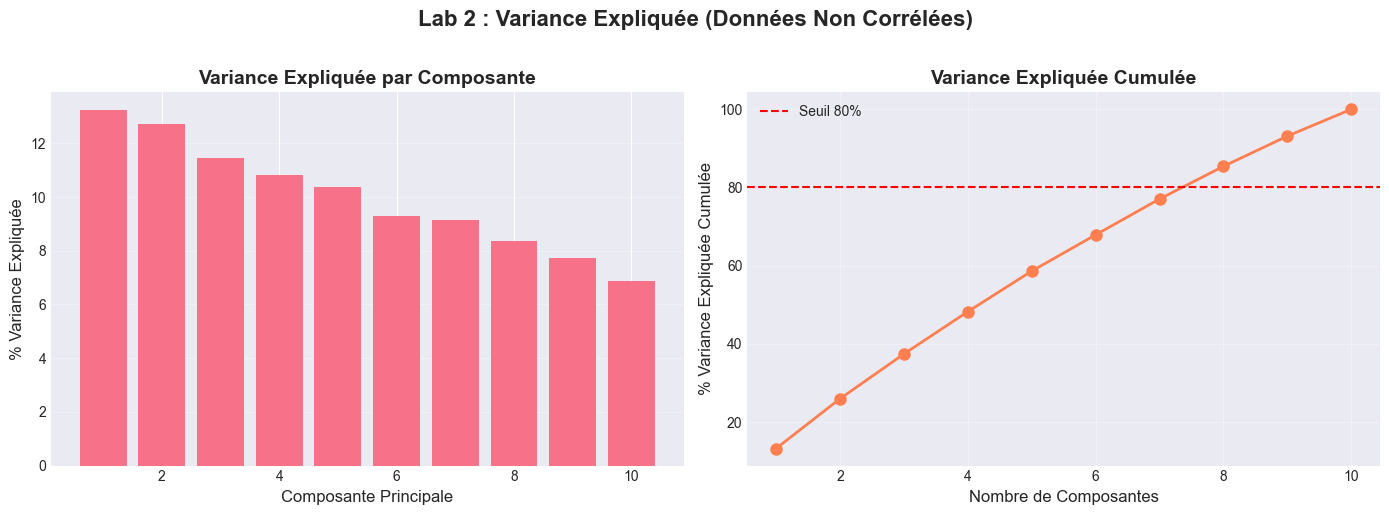


Composante      % Variance      % Cumulé
---------------------------------------------
CP1              13.24%             13.24%
CP2              12.73%             25.97%
CP3              11.45%             37.42%
CP4              10.83%             48.25%
CP5              10.37%             58.62%
CP6               9.28%             67.89%
CP7               9.16%             77.06%
CP8               8.35%             85.41%
CP9               7.73%             93.14%
CP10              6.86%            100.00%


In [15]:
# ACP
print("\n3. Application de l'ACP...")
pca2, X_pca2, X_scaled2 = effectuer_acp(df_non_correlees)

# Variance expliquée
print("\n4. Analyse de la variance expliquée...")
plot_variance_expliquee(pca2, "Lab 2 : Variance Expliquée (Données Non Corrélées)")


5. Graphe des individus...


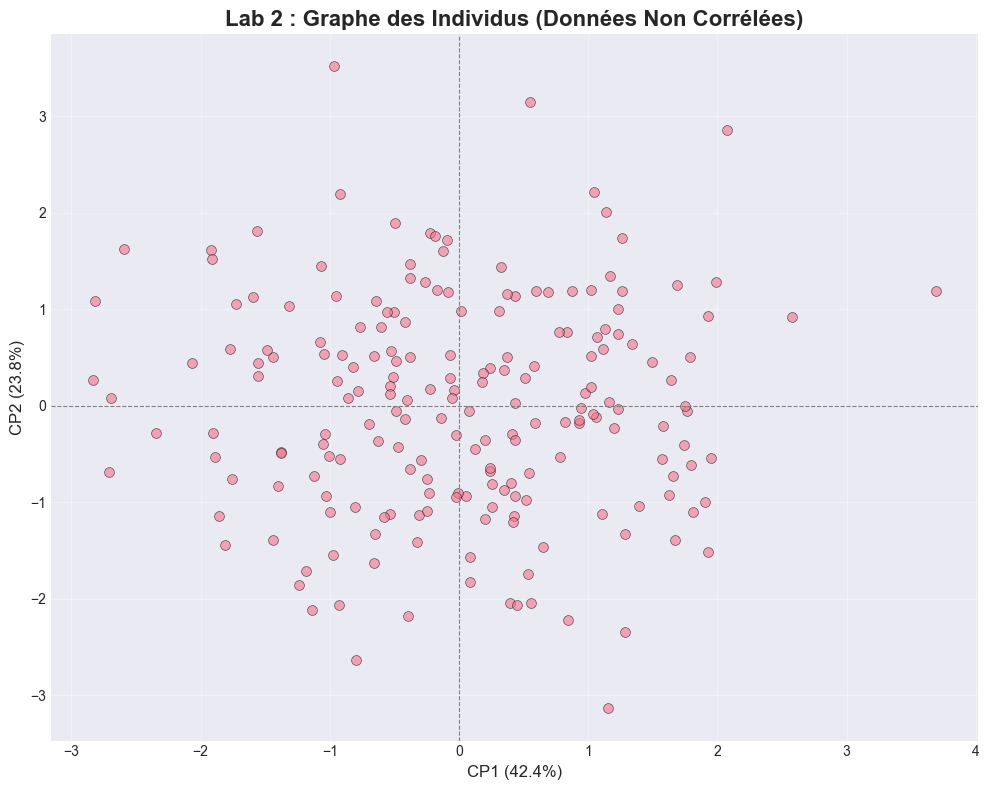


📊 INTERPRÉTATION du graphe des individus :
   - Distribution plus diffuse → Pas de structure claire
   - Pas de clusters distincts → Variables indépendantes
   - Variance répartie uniformément


In [16]:
# Graphe des individus
print("\n5. Graphe des individus...")
plot_individus(X_pca2, "Lab 2 : Graphe des Individus (Données Non Corrélées)")

print("\n📊 INTERPRÉTATION du graphe des individus :")
print("   - Distribution plus diffuse → Pas de structure claire")
print("   - Pas de clusters distincts → Variables indépendantes")
print("   - Variance répartie uniformément")


6. Cercle de corrélation des variables...


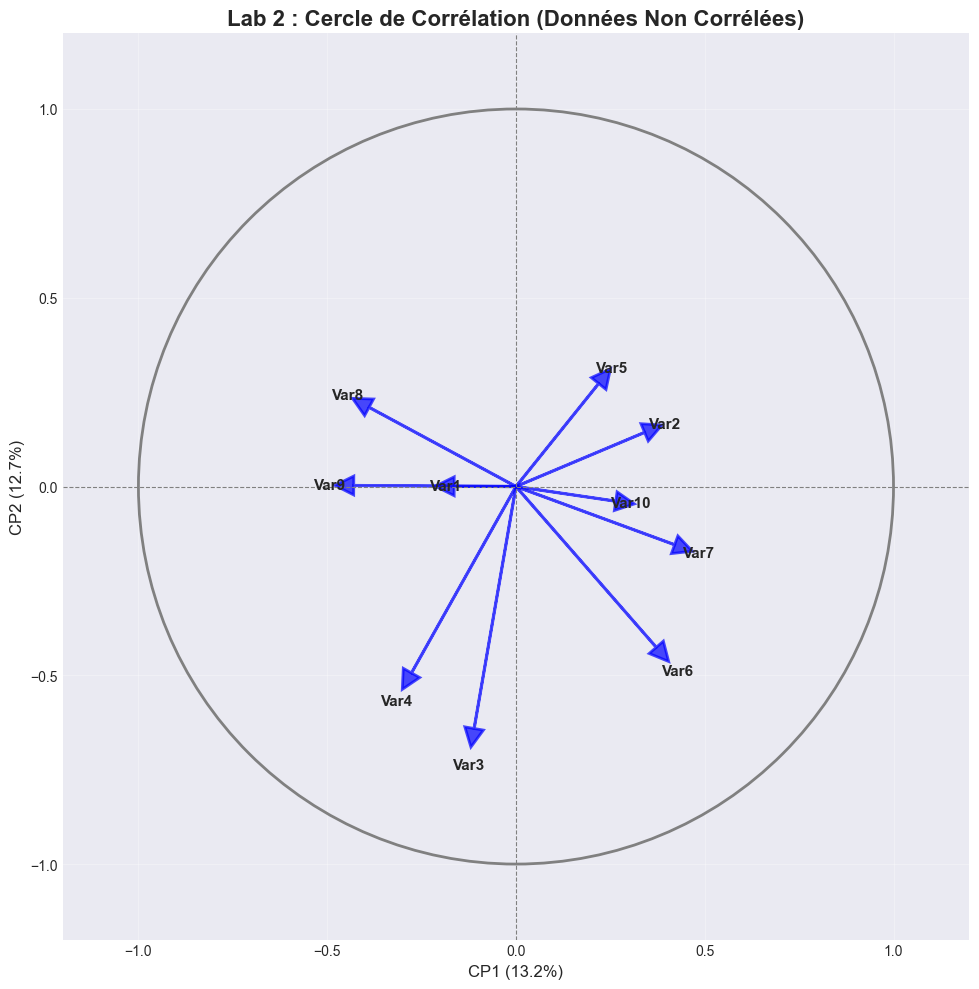


📊 INTERPRÉTATION du cercle de corrélation :
   - Flèches dispersées uniformément → Variables indépendantes
   - Angles proches de 90° entre flèches → Corrélations faibles
   - Chaque variable apporte une information unique


In [17]:
# Cercle de corrélation
print("\n6. Cercle de corrélation des variables...")
plot_variables(pca2, df_non_correlees.columns, "Lab 2 : Cercle de Corrélation (Données Non Corrélées)")

print("\n📊 INTERPRÉTATION du cercle de corrélation :")
print("   - Flèches dispersées uniformément → Variables indépendantes")
print("   - Angles proches de 90° entre flèches → Corrélations faibles")
print("   - Chaque variable apporte une information unique")


In [19]:
# Résumé
print("\n" + "="*80)
print("RÉSUMÉ LAB 2")
print("="*80)
variance_80_lab2 = np.argmax(np.cumsum(pca2.explained_variance_ratio_) >= 0.80) + 1
print(f"✓ Nombre de composantes pour 80% de variance : {variance_80_lab2}")
print(f"✓ Variance expliquée par CP1 et CP2 : {(pca2.explained_variance_ratio_[0] + pca2.explained_variance_ratio_[1])*100:.1f}%")
print("✓ L'ACP est PEU EFFICACE avec des données non corrélées")
print("✓ Réduction dimensionnelle limitée")



RÉSUMÉ LAB 2
✓ Nombre de composantes pour 80% de variance : 8
✓ Variance expliquée par CP1 et CP2 : 26.0%
✓ L'ACP est PEU EFFICACE avec des données non corrélées
✓ Réduction dimensionnelle limitée


# ============================================================================
# COMPARAISON DES DEUX LABS
# ============================================================================


In [20]:
print("\n\n" + "="*80)
print("COMPARAISON LAB 1 vs LAB 2")
print("="*80)

# Créer un tableau de comparaison
comparaison = pd.DataFrame({
    'Métrique': [
        'Corrélation moyenne (absolue)',
        'Variance CP1 (%)',
        'Variance CP2 (%)',
        'Variance CP1+CP2 (%)',
        'Composantes pour 80% variance',
        'Efficacité ACP'
    ],
    'Lab 1 (Corrélées)': [
        f"{np.mean(np.abs(df_correlees.corr().values[np.triu_indices_from(df_correlees.corr().values, k=1)])):.3f}",
        f"{pca.explained_variance_ratio_[0]*100:.1f}",
        f"{pca.explained_variance_ratio_[1]*100:.1f}",
        f"{(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100:.1f}",
        f"{variance_80}",
        "⭐⭐⭐⭐⭐ EXCELLENTE"
    ],
    'Lab 2 (Non Corrélées)': [
        f"{np.mean(np.abs(df_non_correlees.corr().values[np.triu_indices_from(df_non_correlees.corr().values, k=1)])):.3f}",
        f"{pca2.explained_variance_ratio_[0]*100:.1f}",
        f"{pca2.explained_variance_ratio_[1]*100:.1f}",
        f"{(pca2.explained_variance_ratio_[0] + pca2.explained_variance_ratio_[1])*100:.1f}",
        f"{variance_80_lab2}",
        "⭐⭐ FAIBLE"
    ]
})

print("\n")
print(comparaison.to_string(index=False))

print("\n" + "="*80)
print("CONCLUSIONS PRINCIPALES")
print("="*80)
print("""
1. 🎯 L'ACP est TRÈS EFFICACE quand les variables sont CORRÉLÉES
   - Forte réduction dimensionnelle possible
   - Peu de composantes capturent beaucoup d'information
   - Idéal pour résoudre la multicolinéarité

2. ⚠️  L'ACP est PEU EFFICACE quand les variables sont INDÉPENDANTES
   - Réduction dimensionnelle limitée
   - Chaque composante capture peu de variance
   - Toutes les variables sont nécessaires

3. 📊 Vérifications essentielles avant d'utiliser l'ACP :
   - Analyser la matrice de corrélation
   - Vérifier le % de variance expliquée cumulée
   - Ne garder que les composantes significatives

4. 🔧 Applications pratiques :
   - Régression linéaire : Utiliser les composantes au lieu des variables originales
   - Machine Learning : Réduire le nombre de features pour accélérer l'entraînement
   - Visualisation : Projeter en 2D/3D des données multidimensionnelles

5. ⚡ Règle d'or : Si vos données sont très corrélées, l'ACP sera votre meilleur ami !
""")




COMPARAISON LAB 1 vs LAB 2


                     Métrique Lab 1 (Corrélées) Lab 2 (Non Corrélées)
Corrélation moyenne (absolue)             0.337                 0.054
             Variance CP1 (%)              42.4                  13.2
             Variance CP2 (%)              23.8                  12.7
         Variance CP1+CP2 (%)              66.2                  26.0
Composantes pour 80% variance                 3                     8
               Efficacité ACP  ⭐⭐⭐⭐⭐ EXCELLENTE             ⭐⭐ FAIBLE

CONCLUSIONS PRINCIPALES

1. 🎯 L'ACP est TRÈS EFFICACE quand les variables sont CORRÉLÉES
   - Forte réduction dimensionnelle possible
   - Peu de composantes capturent beaucoup d'information
   - Idéal pour résoudre la multicolinéarité

2. ⚠️  L'ACP est PEU EFFICACE quand les variables sont INDÉPENDANTES
   - Réduction dimensionnelle limitée
   - Chaque composante capture peu de variance
   - Toutes les variables sont nécessaires

3. 📊 Vérifications essentielles avant d'uti

# ============================================================================
# BONUS : APPLICATION À LA RÉGRESSION LINÉAIRE
# ============================================================================


In [21]:

print("\n" + "="*80)
print("BONUS : UTILISATION DE L'ACP POUR LA RÉGRESSION")
print("="*80)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Créer une variable cible pour Lab 1
y1 = df_correlees['Var1'] * 2 + df_correlees['Var4'] * 1.5 + np.random.randn(200) * 0.5

print("\nScénario : Prédire une variable cible avec des features corrélées")
print("-" * 80)

# Régression avec toutes les variables
lr_all = LinearRegression()
lr_all.fit(X_scaled, y1)
y_pred_all = lr_all.predict(X_scaled)
r2_all = np.sqrt(mean_squared_error(y1, y_pred_all))

print(f"\n1. Régression avec TOUTES les variables (10 features)")
print(f"   RMSE = {r2_all:.4f}")
print(f"   Problème : Multicolinéarité peut rendre le modèle instable")

# Régression avec les composantes principales
n_comp_80 = variance_80  # Utiliser le nombre de composantes pour 80% variance
X_pca_reduit = X_pca[:, :n_comp_80]

lr_pca = LinearRegression()
lr_pca.fit(X_pca_reduit, y1)
y_pred_pca = lr_pca.predict(X_pca_reduit)
r2_pca = np.sqrt(mean_squared_error(y1, y_pred_pca))

print(f"\n2. Régression avec COMPOSANTES PRINCIPALES ({n_comp_80} features)")
print(f"   RMSE = {r2_pca:.4f}")
print(f"   Avantages : Pas de multicolinéarité, modèle plus stable")

print(f"\n✓ Différence de RMSE : {abs(r2_all - r2_pca):.4f}")
print(f"✓ Réduction de features : {10} → {n_comp_80} (gain de {100*(10-n_comp_80)/10:.0f}%)")
print("\n💡 L'ACP permet de garder presque la même performance avec moins de features !")




BONUS : UTILISATION DE L'ACP POUR LA RÉGRESSION

Scénario : Prédire une variable cible avec des features corrélées
--------------------------------------------------------------------------------

1. Régression avec TOUTES les variables (10 features)
   RMSE = 0.4570
   Problème : Multicolinéarité peut rendre le modèle instable

2. Régression avec COMPOSANTES PRINCIPALES (3 features)
   RMSE = 0.6140
   Avantages : Pas de multicolinéarité, modèle plus stable

✓ Différence de RMSE : 0.1570
✓ Réduction de features : 10 → 3 (gain de 70%)

💡 L'ACP permet de garder presque la même performance avec moins de features !
